conv1 is:GATConv(1, 8, heads=4)
conv2 is:GATConv(32, 16, heads=3)
89
n_nodes = 7289
Number of patients 89
Counter({5561: 19, 2880: 14, 824: 13, 521: 12, 2063: 12, 2183: 12, 170: 12, 88: 12, 1211: 12, 449: 12, 1097: 12, 342: 12, 799: 11, 2792: 11, 889: 11, 5795: 11, 5869: 11, 4943: 11, 2536: 11, 3628: 11, 4271: 11, 3275: 11, 6435: 11, 1234: 11, 1391: 11, 881: 10, 2094: 10, 3292: 10, 3301: 10, 3427: 10, 6172: 10, 6655: 10, 7016: 10, 522: 10, 2495: 10, 2654: 10, 3513: 10, 5794: 10, 7280: 10, 4708: 10, 5467: 10, 395: 10, 1630: 10, 1738: 10, 2840: 10, 6972: 10, 1205: 10, 2672: 10, 3220: 10, 4805: 10, 6783: 10, 2510: 10, 4379: 10, 5657: 10, 1383: 10, 2669: 10, 3248: 10, 6430: 10, 1492: 10, 4877: 10, 6310: 10, 4190: 10, 576: 10, 3553: 10, 6804: 10, 960: 9, 1096: 9, 1099: 9, 3625: 9, 4440: 9, 5241: 9, 5257: 9, 6008: 9, 783: 9, 1832: 9, 1919: 9, 2446: 9, 2846: 9, 3808: 9, 5414: 9, 5624: 9, 6584: 9, 7196: 9, 1212: 9, 1216: 9, 4155: 9, 6064: 9, 6158: 9, 7247: 9, 4134: 9, 4390: 9, 4718: 9, 5165: 9

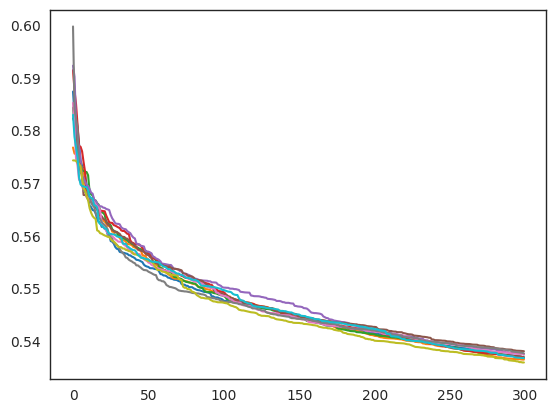

In [55]:
import os
import torch
import torch_geometric
from torch_geometric.explain import GNNExplainer, Explainer
from main import Proteo, AttrDict
from proteo.datasets.ftd import ROOT_DIR, FTDDataset
from config_utils import CONFIG_FILE, read_config_from_file
from models.gat_v4 import GATv4
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter



#Load model checkpoint
module = Proteo.load_from_checkpoint("/home/lcornelis/code/proteo/proteo/checkpoints/ckpt14-05-2024epoch=41.ckpt")

root = os.path.join(ROOT_DIR, "data", "ftd")
config = read_config_from_file(CONFIG_FILE)
model_parameters = getattr(config, config.model)
model_parameters = AttrDict(model_parameters)
test_dataset = FTDDataset(root, "test", config)
train_dataset = FTDDataset(root, "train", config)

# Choose dataset
dataset = test_dataset

# test_loader = DataLoader(  # makes into one big graph
#         test_dataset,
#         batch_size=config.batch_size,
#         shuffle=True,
#         num_workers=config.num_workers,
#         pin_memory=config.pin_memory,
#     )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Explainer
explainer = Explainer(
model=module.model.to(device),
algorithm=GNNExplainer(epochs=5),
explanation_type='model',
model_config=dict(
    mode='regression',
    task_level='graph',  # Explain why the model predicts a certain property or label for the entire graph (nodes + edges)
    return_type='raw'
),
node_mask_type='object', # Generate masks that indicate the importance of individual node features
edge_mask_type=None,
threshold_config=dict(
    threshold_type='topk',
    value=300,
),
)

# Function to visualize node importance
def visualize_node_importance(data, node_importance):
    # Convert to networkx graph
    G = torch_geometric.utils.to_networkx(data, to_undirected=True)

    # Get node positions
    pos = nx.spring_layout(G)

    # Plot nodes with color based on importance
    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos,
        node_color=node_importance,
        node_size=200,
        cmap=plt.cm.Reds,
        with_labels=True
    )
    plt.title('Node Importance Visualization')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Reds), label='Importance')
    plt.show()

i = 0 
all_proteins = []
print(len(dataset))
n_nodes = len(dataset[0].x)
print(f"n_nodes = {n_nodes}")
sum_node_importance = np.zeros((n_nodes, 1))
for data in dataset:
    data_attributes = data.keys
    # Ensure data.x and data.edge_index are tensors
    if not isinstance(data.x, torch.Tensor) or not isinstance(data.edge_index, torch.Tensor):
        raise TypeError("data.x and data.edge_index must be torch.Tensor")
    #print(f'Batch actual attributes: {data_attributes}')
    explanation = explainer(
        data.x,
        data.edge_index,
        data=data,
        target=None,
        index=None
    )
    #print(f'Generated explanations in {explanation.available_explanations}')
    # Node_importance is of format [[0], [0],[0],...,[.5]] with length equal to the number of nodes
    node_importance = explanation.node_mask.cpu().detach().numpy()
    if i < 10:
        plt.plot(sorted(node_importance, reverse=True)[:300])

    # Find row indices of non-zero elements in node_importance
    indv_important_proteins = np.nonzero(node_importance)[0]
    all_proteins.append(indv_important_proteins)
    sum_node_importance += np.array(node_importance)
    i += 1

print("Number of patients", i)
# Flatten the list of lists into a single list
full_count = [item for sublist in all_proteins for item in sublist]

# Use Counter to count the occurrences of each element
protein_count = Counter(full_count)
print(protein_count)
print(len(protein_count))


In [45]:
sum_node_importance.shape

(7289, 1)

In [39]:
import matplotlib.pyplot as plt

# Assuming `protein_count` is your Counter object
protein_ids = list(protein_count.keys())
counts = list(protein_count.values())

#Sort the proteins by counts in decreasing order
sorted_proteins = sorted(zip(protein_ids, counts), key=lambda x: x[1], reverse=True)

# Unzip the sorted list back into two lists
protein_ids, counts = zip(*sorted_proteins)
print(protein_ids)
protein_ids = [str(p) for p in protein_ids]


(6546, 607, 2183, 5794, 3275, 881, 388, 945, 6026, 650, 1214, 947, 1029, 1096, 2536, 1254, 1212, 3294, 2797, 3105, 1755, 816, 901, 2654, 5132, 5258, 6617, 3183, 4259, 6884, 275, 1656, 6151, 2347, 1492, 2381, 5827, 2880, 4412, 6763, 1217, 2114, 2545, 3767, 6333, 1683, 4610, 6954, 2409, 618, 449, 4859, 1084, 5666, 1654, 1794, 5362, 2201, 3427, 4993, 2071, 1388, 1573, 3938, 4439, 6417, 7187, 503, 5531, 6927, 1443, 3247, 5644, 7245, 1193, 2447, 4785, 2244, 4706, 1787, 1818, 2025, 811, 2186, 363, 578, 6594, 5232, 7198, 1715, 6009, 3024, 6816, 2053, 2431, 3301, 6169, 4013, 536, 1819, 6517, 1211, 3587, 6225, 295, 2660, 4194, 4271, 7247, 859, 956, 1667, 5273, 1336, 2219, 2695, 608, 1439, 2495, 2781, 917, 3701, 6690, 7046, 3305, 5243, 6093, 4858, 3303, 824, 266, 2954, 4752, 5285, 5674, 1177, 2819, 5858, 712, 7020, 128, 229, 3993, 6171, 4943, 5937, 1630, 3726, 1582, 3962, 5475, 6011, 3179, 4257, 4711, 6403, 4758, 5652, 1883, 6746, 960, 2790, 4521, 490, 776, 1662, 522, 244, 7171, 1239, 684, 6326,

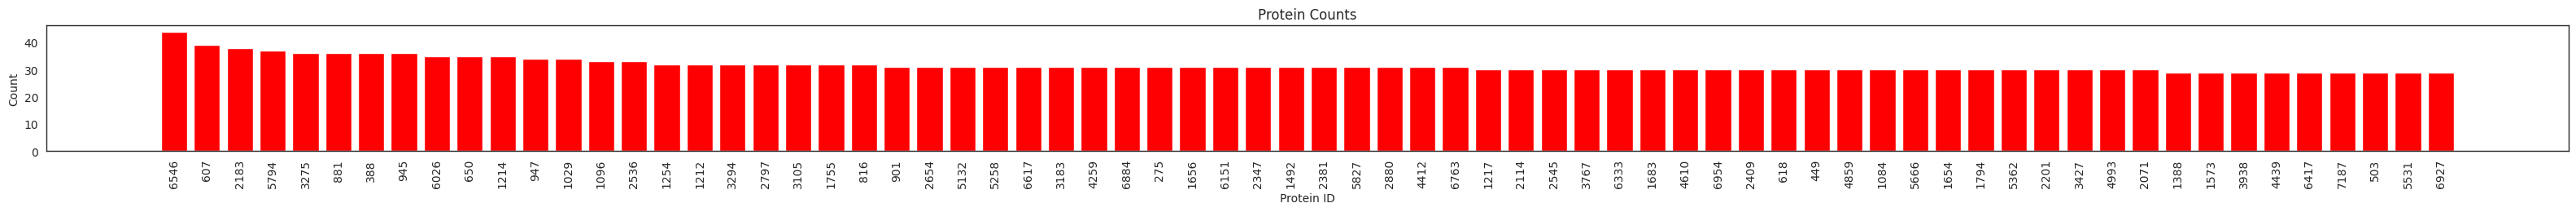

In [40]:
# Create the bar plot
top_k = 70
plt.figure(figsize=(40, 2))  # Adjust as needed
plt.bar(protein_ids[:top_k], counts[:top_k], color="red")
plt.xlabel('Protein ID')
plt.ylabel('Count')
plt.title('Protein Counts')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility if they are long
plt.show()

array([[2.73296392],
       [1.08230257],
       [1.08526909],
       [2.18780655],
       [3.86089438],
       [1.10714352],
       [0.54976016],
       [1.68710524],
       [2.21770883],
       [1.08070755]])

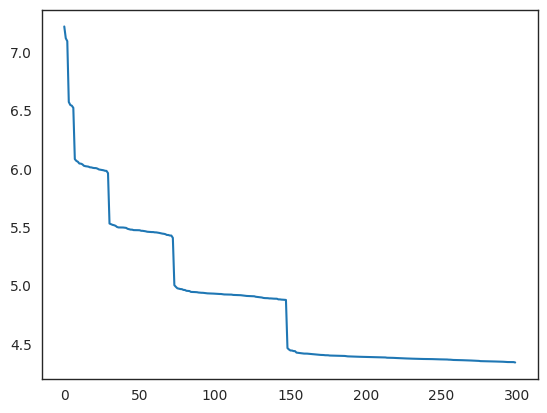

In [51]:
plt.plot(sorted(sum_node_importance, reverse=True)[:300])
sum_node_importance[:10]
print(sorted(node_importance, reverse=True)[:])